# SDS110 – Lab 5: RiverREM in Google Colab

In this notebook you will:

- Upload a DEM to Colab
- Run the RiverREM tool to create a Relative Elevation Model (REM)
- Visualize the REM with:
- Explore how color range (vmin/vmax) and colormap choice influence interpretation

The DEM must actually contain a river that is mapped in OSM; otherwise RiverREM will raise an error like “No rivers found within the DEM domain”. Verify if you can find your river in OSM: https://www.openstreetmap.org

In [1]:
# STEP 1 – Install system packages (GDAL) and Python packages

!apt-get update -y
!apt-get install -y gdal-bin python3-gdal

# GDAL bindings + geospatial libs + Crameri colormaps + RiverREM from GitHub
!pip install --no-cache-dir \
  GDAL==3.8.4 \
  rasterio \
  geopandas \
  "osmnx==1.7.1" \
  cmocean \
  cmcrameri \
  seaborn \
  "git+https://github.com/opentopography/RiverREM.git"

# Quick check: RiverREM should be installed
!pip show riverrem


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy

In [3]:
import os

# --- IMPORTANT ---------------------------------------------------------
# This folder must contain YOUR DEM file.
#
# 1) Run this cell.
# 2) Open the left sidebar → "Files" tab.
# 3) Navigate to /content/DEM.
# 4) Upload (drag & drop) your DEM file (e.g. DEM_Shannadoah_uint16_10m.tif).
# 5) Run this cell again to verify your DEM upload (DEM folder contents: 'your_DEM.tif')
# -----------------------------------------------------------------------

os.makedirs("/content/DEM", exist_ok=True)

print("Root folder contents:", os.listdir("/content"))
print("DEM folder contents:", os.listdir("/content/DEM"))


Root folder contents: ['.config', 'DEM', 'sample_data']
DEM folder contents: ['DEM_Shannadoah_uint16_10m.tif']


In [4]:
# === USER SETTINGS =====================================================
# Edit this block for your own data / visualization choices.

DEM_FILENAME   = "DEM_Shannadoah_uint16_10m.tif"  # Assign the name of your uploaded DEM in /content/DEM
CMAP_NAME      = "batlow"      # Crameri colormap name (see list below)
BLEND_PERCENT  = 60            # 0–100, how strong the hillshade effect is
VMIN_MANUAL    = None          # e.g. 0 or None for automatic
VMAX_MANUAL    = None          # e.g. 30 or None for automatic

# Suggested sequential Crameri colormaps:
# batlow, batlowK, batlowW, lajolla, lapaz, bamako,
# oslo, tokyo, hawaii, davos, lisbon, acton, bilbao,
# bologna, nuuk
# ======================================================================


In [5]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors
import cmcrameri.cm as cmc


def build_paths(dem_filename):
    """Build full DEM and REM paths from the DEM filename."""
    dem_path = f"/content/DEM/{dem_filename}"
    base = os.path.splitext(dem_filename)[0]
    rem_path = f"/content/output/{base}_REM.tif"
    return dem_path, rem_path


def load_rem_and_dem(rem_path, dem_path):
    """Load REM and DEM as numpy arrays and return rem, dem, and transform."""
    if not os.path.exists(dem_path):
        raise FileNotFoundError(
            f"DEM not found at {dem_path}.\n"
            "Did you upload it into /content/DEM and set DEM_FILENAME correctly?"
        )
    if not os.path.exists(rem_path):
        raise FileNotFoundError(
            f"REM not found at {rem_path}.\n"
            "Did you run the RiverREM step (make_rem) successfully?"
        )

    with rasterio.open(rem_path) as rem_src:
        rem = rem_src.read(1).astype("float32")
        rem_profile = rem_src.profile
        rem_nodata = rem_profile.get("nodata", None)

    if rem_nodata is not None:
        rem = np.where(rem == rem_nodata, np.nan, rem)

    with rasterio.open(dem_path) as dem_src:
        dem = dem_src.read(1).astype("float32")
        transform = dem_src.transform

    return rem, dem, transform


def plot_rem_with_hillshade(rem, dem, transform, cmap,
                            blend_percent=60,
                            vmin=None, vmax=None):
    """
    Plot a REM blended with hillshade.

    - rem, dem: 2D arrays
    - transform: affine transform from DEM
    - cmap: Matplotlib colormap (e.g., cmc.batlow)
    - blend_percent: 0–100, how strong the hillshade effect is
    - vmin, vmax: color range for REM (None = automatic percentiles)
    """

    # 1) Determine vmin/vmax (automatic or manual)
    if vmin is None or vmax is None:
        vmin_auto, vmax_auto = np.nanpercentile(rem, (2, 98))
        vmin = vmin if vmin is not None else vmin_auto
        vmax = vmax if vmax is not None else vmax_auto

    print(f"REM color range used: vmin={vmin:.2f}, vmax={vmax:.2f}")

    # 2) Normalize REM
    rem_norm = (rem - vmin) / (vmax - vmin)
    rem_norm = np.clip(rem_norm, 0, 1)

    # 3) Hillshade from DEM
    dx = transform.a
    dy = -transform.e  # usually negative

    gy, gx = np.gradient(dem, dy, dx)
    slope = np.pi/2.0 - np.arctan(np.sqrt(gx * gx + gy * gy))
    aspect = np.arctan2(-gx, gy)

    az = np.deg2rad(315)   # azimuth (direction of light)
    alt = np.deg2rad(45)   # altitude (height of sun)

    hs = (np.sin(alt) * np.sin(slope) +
          np.cos(alt) * np.cos(slope) * np.cos(az - aspect))

    hs_min, hs_max = np.nanmin(hs), np.nanmax(hs)
    hs_norm = (hs - hs_min) / (hs_max - hs_min)
    hs_norm = np.clip(hs_norm, 0, 1)

    # 4) Colorize REM
    rgba = cmap(rem_norm)
    rgba[..., 3] = 1.0  # fully opaque

    # 5) Blend hillshade + REM colors
    w_hs = blend_percent / 100.0
    w_col = 1.0 - w_hs

    hs_rgb = np.repeat(hs_norm[..., None], 3, axis=2)
    blended_rgb = w_col * rgba[..., :3] + w_hs * hs_rgb
    blended = np.dstack([blended_rgb, rgba[..., 3]])

    # Mask NaNs in REM → transparent
    mask = np.isnan(rem)
    blended[mask] = [1, 1, 1, 0]

    # 6) Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(blended)
    ax.set_title("REM with Transparent Hillshade")
    ax.axis("off")

    mappable = plt.cm.ScalarMappable(
        norm=colors.Normalize(vmin=vmin, vmax=vmax),
        cmap=cmap
    )
    cbar = fig.colorbar(mappable, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Relative Elevation (m)")

    plt.show()


In [6]:
# STEP – Run RiverREM once to create the REM from the DEM

import sys
from osgeo import gdal as _gdal, ogr as _ogr, osr as _osr

# Make osgeo.gdal/ogr/osr available under the names RiverREM expects
sys.modules["gdal"] = _gdal
sys.modules["ogr"] = _ogr
sys.modules["osr"] = _osr

from riverrem.REMMaker import REMMaker
import os

# Build paths and prepare output directory
dem_path, rem_path = build_paths(DEM_FILENAME)
out_dir = "/content/output"
os.makedirs(out_dir, exist_ok=True)

print("DEM path:", dem_path)
print("REM will be saved as:", rem_path)

# Run RiverREM
rem_maker = REMMaker(dem=dem_path, out_dir=out_dir)
rem_maker.make_rem()           # creates the REM GeoTIFF
rem_maker.make_rem_viz(cmap="topo")  # optional: RiverREM's own viz

print("Output directory contents:", os.listdir(out_dir))


DEM path: /content/DEM/DEM_Shannadoah_uint16_10m.tif
REM will be saved as: /content/output/DEM_Shannadoah_uint16_10m_REM.tif


/usr/local/lib/python3.12/dist-packages/riverrem/REMMaker.py:239: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  self.rivers = osmnx.geometries_from_bbox(*self.bbox, tags={'waterway': ['river', 'stream', 'tidal channel']})



Making multidirectional hillshade raster.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Tiling and compressing raster.
Saved ./.cache/DEM_Shannadoah_uint16_10m_hillshade.tif.

Making color relief map with cmap=topo.
Tiling and compressing raster.
Saved ./.cache/DEM_Shannadoah_uint16_10m_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/DEM_Shannadoah_uint16_10m_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved /content/output/DEM_Shannadoah_uint16_10m_hillshade-color.tif.

Generating .png file.
Saved /content/output/DEM_Shannadoah_uint16_10m_hillshade-color.png.
Output directory contents: ['DEM_Shannadoah_uint16_10m_river_pts.shx', 'DEM_Shannadoah_uint16_10m_river_pts.prj', 'DEM_Shannadoah_uint16_10m_hillshade-color.png.aux.xml', 'DEM_Shannadoah_uint16_10m_river_pts.shp', 'DEM_Shannadoah_uint16_10m_hillshade-color.png', 'DEM_Shannadoah_uint16_10m_river_pts.dbf', 'DEM_Shannadoah_uint16_10m_REM.tif', 'DEM_Shannadoah_uint16_10m_hillshade-color.tif']


DEM path: /content/DEM/DEM_Shannadoah_uint16_10m.tif
REM path: /content/output/DEM_Shannadoah_uint16_10m_REM.tif
Using colormap: batlow, hillshade blend: 60%
REM color range used: vmin=0.00, vmax=43937.00


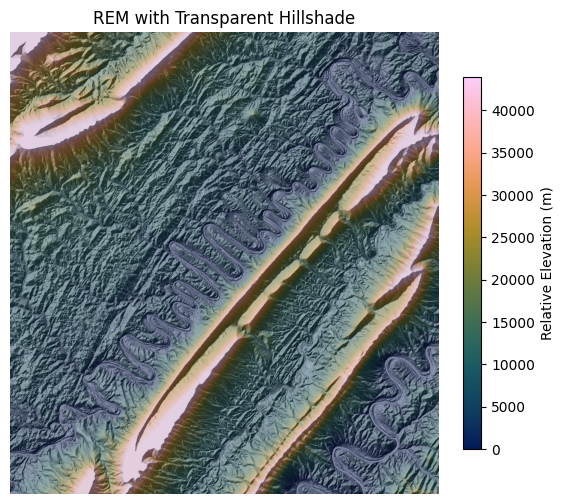

In [7]:
# STEP – Visualize the REM with hillshade and a Crameri colormap

# Build paths again (in case this cell is run standalone)
dem_path, rem_path = build_paths(DEM_FILENAME)

print("DEM path:", dem_path)
print("REM path:", rem_path)

# Load data
rem, dem, transform = load_rem_and_dem(rem_path, dem_path)

# Pick Crameri colormap
cmap = getattr(cmc, CMAP_NAME)

print(f"Using colormap: {CMAP_NAME}, hillshade blend: {BLEND_PERCENT}%")

# Plot
plot_rem_with_hillshade(
    rem, dem, transform,
    cmap=cmap,
    blend_percent=BLEND_PERCENT,
    vmin=VMIN_MANUAL,
    vmax=VMAX_MANUAL
)


## Reflection

1. Change the colormap (e.g., `batlow` → `lajolla` → `oslo`).  
   - How does this change your perception of “high” and “low” areas?

2. Change `BLEND_PERCENT` (e.g., 20, 60, 90).  
   - When does the hillshade help? When does it start to dominate too much?

3. Try setting `VMIN_MANUAL` and `VMAX_MANUAL` to fixed values.  
   - What happens if the range is too narrow vs. too wide?

4. How might this visualization help you interpret floodplain structure or river morphology more effectively than a raw DEM?
